In [1]:
import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-base-plus")

In [3]:
img_path = "/home/vagarwal/RIPS25-AnalogDevices-ObjectDetection/src/utils/Clock.avif"
img = Image.open(img_path)

In [4]:
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(img)
    masks, scores, _ = predictor.predict()
    highest_score_idx = scores.argmax()
    mask = masks[highest_score_idx]

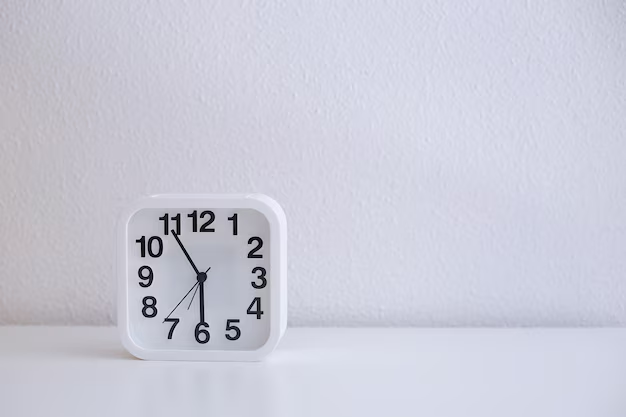

In [5]:
img

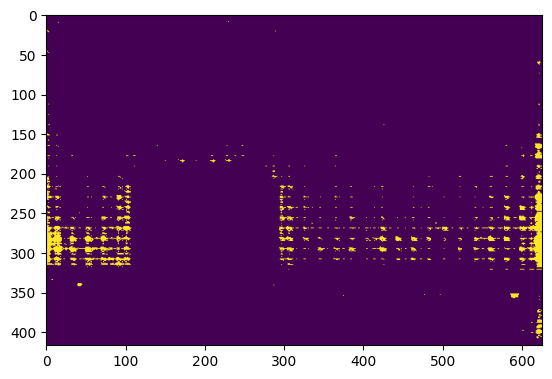

In [ ]:
plt.imshow(mask)

In [ ]:
result[0].masks.data.shape

# Original Code

In [ ]:
import os
import sys
from ultralytics import SAM
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
from PIL import Image
from ultralytics.data.utils import visualize_image_annotations

In [ ]:
model = SAM("sam2.1_b.pt")

In [ ]:
result = model(img_path)

In [ ]:
# Class folders should be organized as follows:
#
# raw/
# └── screwdriver_kaggle/
#    ├── screwdriver/
#    │   ├── images/
#    │   │   ├── 1.jpg
#    │   │   └── ...
#    │   ├── labels/
#    │   │   ├── 1.txt
#    │   │   └── ...
#    │   ├── masks/
#    │   │   ├── 1_mask.png
#    │   │   └── ...  
#    ├── hammer/
#    │   └── .../
#    ├── .../
#    └── classes.txt

# Darknet files should have the following format:
# class_index x_center y_center width height
#
# e.g.
# 0 0.5 0.5 0.2 0.2

# classes.txt should contain the class names, one per line:
# e.g.
# screwdriver
# hammer
# ...

raw_dataset_name = 'kaggle_v0'
cnp_output_name = 'cut_and_paste_root2'
output_dataset_name = 'cut_and_paste_vik_test'
object_classes = ['screwdriver', 'hammer', 'plier', 'trowel', 'wrench', 'tape_measure']
class_dirs = [f'/home/data/raw/{raw_dataset_name}/{object_class}/' for object_class in object_classes]
output_dirs = class_dirs
# output_dirs = [f'/home/data/raw/{raw_dataset_name}/{cnp_output_name}/{object_class}/' for object_class in object_classes]
# output_dirs = [f'/home/data/raw/{project_name}/{object_class}/' for object_class in object_classes]


## Segment w SAM2

In [ ]:
def read_darknet_bboxes(bbox_path, image_width, image_height):
	"""Read bounding boxes from darknet format file and convert to pixel coordinates"""
	bboxes = []
	
	with open(bbox_path, 'r') as f:
		for line in f:
			parts = line.strip().split()
			assert len(parts) == 5, f"Invalid bbox line: {line.strip()}"
			
			# Darknet format: class_id x_center y_center width height (normalized)
			class_id = int(parts[0])
			x_center = float(parts[1])
			y_center = float(parts[2])
			width = float(parts[3])
			height = float(parts[4])
			
			# Convert from normalized coordinates to pixel coordinates
			x_center_px = x_center * image_width
			y_center_px = y_center * image_height
			width_px = width * image_width
			height_px = height * image_height
			
			# Convert to x1, y1, x2, y2 format
			x1 = int(x_center_px - width_px / 2)
			y1 = int(y_center_px - height_px / 2)
			x2 = int(x_center_px + width_px / 2)
			y2 = int(y_center_px + height_px / 2)
			
			# Ensure coordinates are within image bounds
			x1 = max(0, min(x1, image_width - 1))
			y1 = max(0, min(y1, image_height - 1))
			x2 = max(0, min(x2, image_width - 1))
			y2 = max(0, min(y2, image_height - 1))
			
			bboxes.append([x1, y1, x2, y2])

	return bboxes

def segment_images_from_folder_bbox(class_dir, output_dir):
    """
    Segments images in the specified folder using the SAM model with bbox information.
    Assumes class_dir contains two folders: 'images_resized' and 'labels'.
    Each image in 'images_resized' should have a corresponding label file in 'labels' with
    bounding box information in the format: x y w h (where x, y are the
    top-left corner coordinates and w, h are the width and height of the bounding box).
    """
    global results
    model = SAM("sam2.1_l.pt")

    for image_path, bbox_path in list(zip(sorted(glob.glob(os.path.join(class_dir, 'images', '*'))), 
                                          sorted(glob.glob(os.path.join(class_dir, 'labels', '*.txt'))))):
        image_dimensions = cv2.imread(image_path).shape
        bboxes = read_darknet_bboxes(bbox_path, image_dimensions[1], image_dimensions[0])
        
        # Predict segmentation using the SAM model with bounding box
        results = model(image_path, bboxes=bboxes)
        # visualize_image_annotations(image_path, bbox_path, output_dir)
        for result in results:
            # Access the masks
            masks = results[0].masks

            # Assuming single class segmentation for simplicity, adjust as needed
            mask = masks[0].data.squeeze().cpu().numpy()  # For multi-class, iterate over masks
            mask = mask.astype(np.uint8) # Convert mask to uint8 if needed)
            mask = cv2.resize(mask, (image_dimensions[1], image_dimensions[0]))
            
            image = cv2.imread(image_path)
            image = cv2.resize(image, (image_dimensions[1], image_dimensions[0]))
            
            # Negate the mask and mask the image
            negative_mask = 1-mask
            negative_image = cv2.bitwise_not(image)
            negative_image = cv2.bitwise_and(negative_image, negative_image, mask=mask)
            masked_image = cv2.bitwise_not(negative_image)
            
            # Uncomment to see the negated masks
            # plt.imshow(negative_mask, cmap='gray')
            # plt.axis('off')
            # plt.show()

            # Uncomment to plot the masked images
            # plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.show()

            os.mkdir(output_dir) if not os.path.exists(output_dir) else None
            for subdir in ['images', 'masks', 'labels']:
            # Create subdirectories if they do not exist
                subdir_path = os.path.join(output_dir, subdir)
                if not os.path.exists(subdir_path): 
                    os.mkdir(subdir_path)
                    
            cv2.imwrite(os.path.join(output_dir, 'masks', os.path.basename(image_path).split('.')[0] + '_mask.png'), negative_mask*255)


In [ ]:
# if not os.path.exists(f'/home/data/raw/{raw_dataset_name}/{cnp_output_name}/'):
#     os.mkdir(f'/home/data/raw/{raw_dataset_name}/{cnp_output_name}')

# os.system(f"cp /home/data/raw/{raw_dataset_name}/classes.txt /home/data/raw/{raw_dataset_name}/{cnp_output_name}/")

# for class_dir, output_dir in list(zip(class_dirs, output_dirs)):
# 	segment_images_from_folder_bbox(class_dir, output_dir)